# Importing needed libraries

In [59]:
!pip install xgboost
!pip install -U imbalanced-learn
!pip install category_encoders

In [60]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.linear_model import LogisticRegression

In [61]:
from google.colab import drive
drive.mount('/content/drive')

#importing the original dataset and assigning to a dataframe
studentDropout_dataset = pd.read_csv('/content/drive/MyDrive/FDM Project/SchoolDropout.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
studentDropout_dataset.head()

,school,sex,age,address,Family Size,Parents' Cohabitation Status,Mother's education,Father's education,Mother's job,Father's job,...,access to internet,In romantic relationship or not,famrel,freetime after school,Going Out,Workday Alchohol Consumption,Weekend Alchohol Consumption,health,absences,dropout
0,Gabriel Pereira,Female,18,Urban,Greater than 3,Apart,higher education,higher education,at_home,teacher,...,no,no,Good,moderate,regularly,Very Low,very low,average,6,yes
1,Gabriel Pereira,Female,17,Urban,Greater than 3,Living Together,4th grade,4th grade,at_home,other,...,yes,no,Excellent,moderate,occasionally,Very Low,very low,average,4,yes
2,Gabriel Pereira,Female,15,Urban,Less or equal to 3,Living Together,4th grade,4th grade,at_home,other,...,yes,no,Good,moderate,rarely,Low,average,average,10,no
3,Gabriel Pereira,Female,15,Urban,Greater than 3,Living Together,higher education,9th grade,health,services,...,yes,yes,Average,limited,rarely,Very Low,very low,very good,2,no
4,Gabriel Pereira,Female,16,Urban,Greater than 3,Living Together,12th grade,12th grade,other,other,...,no,no,Good,moderate,rarely,Very Low,low,very good,4,no


In [63]:
print(studentDropout_dataset.dtypes)

school                                    object
sex                                       object
age                                        int64
address                                   object
Family Size                               object
Parents' Cohabitation Status              object
Mother's education                        object
Father's education                        object
Mother's job                              object
Father's job                              object
reason to choose school                   object
guardian                                  object
traveltime (home to school)               object
weekly study time                         object
past class failures                        int64
schoolsup                                 object
famsup                                    object
takes extra paid classes                  object
extra-curricular activities               object
nursery                                   object
willingness to pursu

In [64]:
#checking for number of columns and rows in the dataset
studentDropout_dataset.shape

(395, 31)

In [65]:
categorical_columns = studentDropout_dataset.select_dtypes(include=['object']).columns.tolist()
numerical_columns = studentDropout_dataset.select_dtypes(exclude=['object']).columns.tolist()

# Count the number of categorical and numerical columns
num_categorical_columns = len(categorical_columns)
num_numerical_columns = len(numerical_columns)

print("\nNumber of Categorical Columns:", num_categorical_columns)
print("Number of Numerical Columns:", num_numerical_columns)


Number of Categorical Columns: 28
Number of Numerical Columns: 3


In [66]:
columns_to_drop = ['school', 'address', 'guardian', 'famsup', 'nursery', 'famrel', 'absences']
studentDropout_dataset = studentDropout_dataset.drop(columns=columns_to_drop)

In [67]:
new_column_names = {
    'Family Size': 'famsize',
    "Parents' Cohabitation Status": 'p_cstatus',
    "Mother's education": 'medu',
    "Father's education" : 'fedu',
    "Mother's job" : 'mjob',
    "Father's job" : 'fjob',
    'reason to choose school' : 'reason',
    'traveltime (home to school)' : 'tTime',
    'weekly study time ' : 'w_sTime',
    'past class failures' : 'pc_failures',
    'takes extra paid classes' : 'paid',
    'extra-curricular activities' : 'activities',
    'willingness to pursue higher education' : 'passion',
    'access to internet' : 'internet',
    'In romantic relationship or not' : 'relationship',
    'freetime after school' : 'ftime',
    'Going Out' : 'goingOut',
    'Workday Alchohol Consumption' : 'Dalc',
    'Weekend Alchohol Consumption' : 'Walc'
}

studentDropout_dataset.rename(columns=new_column_names, inplace=True)

In [68]:
studentDropout_dataset.head()

,sex,age,famsize,p_cstatus,medu,fedu,mjob,fjob,reason,tTime,...,activities,passion,internet,relationship,ftime,goingOut,Dalc,Walc,health,dropout
0,Female,18,Greater than 3,Apart,higher education,higher education,at_home,teacher,course,15 to 30 min,...,no,yes,no,no,moderate,regularly,Very Low,very low,average,yes
1,Female,17,Greater than 3,Living Together,4th grade,4th grade,at_home,other,course,<15 min,...,no,yes,yes,no,moderate,occasionally,Very Low,very low,average,yes
2,Female,15,Less or equal to 3,Living Together,4th grade,4th grade,at_home,other,other,<15 min,...,no,yes,yes,no,moderate,rarely,Low,average,average,no
3,Female,15,Greater than 3,Living Together,higher education,9th grade,health,services,home,<15 min,...,yes,yes,yes,yes,limited,rarely,Very Low,very low,very good,no
4,Female,16,Greater than 3,Living Together,12th grade,12th grade,other,other,home,<15 min,...,no,yes,no,no,moderate,rarely,Very Low,low,very good,no


In [69]:
studentDropout_dataset.describe()

,age,pc_failures
count,395.000000,395.000000
mean,16.696203,0.334177
std,1.276043,0.743651
min,15.000000,0.000000
25%,16.000000,0.000000
50%,17.000000,0.000000
75%,18.000000,0.000000
max,22.000000,3.000000


# Encoding of categorical features

In [70]:
# Perform one-hot encoding on the "sex" column
studentDropout_dataset = pd.get_dummies(studentDropout_dataset, columns=['sex'], prefix=['Gender'])

In [71]:
# Perform one-hot encoding on the "famisize" column
studentDropout_dataset = pd.get_dummies(studentDropout_dataset, columns=['famsize'], prefix=['famsize'])


In [72]:
# Perform one-hot encoding on the "p_cstatus" column
studentDropout_dataset = pd.get_dummies(studentDropout_dataset, columns=['p_cstatus'], prefix=['p_cstatus'])

In [73]:
studentDropout_dataset.head()

,age,medu,fedu,mjob,fjob,reason,tTime,w_sTime,pc_failures,schoolsup,...,Dalc,Walc,health,dropout,Gender_Female,Gender_Male,famsize_Greater than 3,famsize_Less or equal to 3,p_cstatus_Apart,p_cstatus_Living Together
0,18,higher education,higher education,at_home,teacher,course,15 to 30 min,2 to 5 hours,0,yes,...,Very Low,very low,average,yes,1,0,1,0,1,0
1,17,4th grade,4th grade,at_home,other,course,<15 min,2 to 5 hours,0,no,...,Very Low,very low,average,yes,1,0,1,0,0,1
2,15,4th grade,4th grade,at_home,other,other,<15 min,2 to 5 hours,3,yes,...,Low,average,average,no,1,0,0,1,0,1
3,15,higher education,9th grade,health,services,home,<15 min,5 to 10 hours,0,no,...,Very Low,very low,very good,no,1,0,1,0,0,1
4,16,12th grade,12th grade,other,other,home,<15 min,2 to 5 hours,0,no,...,Very Low,low,very good,no,1,0,1,0,0,1


In [74]:
# Sample DataFrame with "Mother's Education" column
data = {'medu': ["none","4th grade", "9th grade", "12th grade", "higher education"]}
df = pd.DataFrame(data)

# Define a mapping for the education levels
education_mapping = {
    "none" : 0,
    "4th grade": 1,
    "9th grade": 2,
    "12th grade": 3,
    "higher education": 4
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['medu'] = studentDropout_dataset['medu'].map(education_mapping).astype(int)


In [75]:
# Sample DataFrame with "father's Education" column
data = {'fedu': ["none","4th grade", "9th grade", "12th grade", "higher education"]}
df = pd.DataFrame(data)

# Define a mapping for the education levels
education_mapping = {
    "none" : 0,
    "4th grade": 1,
    "9th grade": 2,
    "12th grade": 3,
    "higher education": 4
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['fedu'] = studentDropout_dataset['fedu'].map(education_mapping).astype(int)


In [76]:
# Sample DataFrame with travel time column
data = {'tTime': ["15 to 30 min","<15 min", "30 min to 1 hour", ">1 hour"]}
df = pd.DataFrame(data)

# Define a mapping for the travel time categories
tTime_mapping = {
    "<15 min" : 0,
    "15 to 30 min": 1,
    "30 min to 1 hour": 2,
    ">1 hour": 3
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['tTime'] = studentDropout_dataset['tTime'].map(tTime_mapping).astype(int)

In [77]:
# Sample DataFrame with weekly study time column
data = {'w_sTime': ["<2 hours","2 to 5 hours", "5 to 10 hours", ">10 hours"]}
df = pd.DataFrame(data)

# Define a mapping for the weekly study time categories
w_sTime_mapping = {
    "<2 hours" : 0,
    "2 to 5 hours": 1,
    "5 to 10 hours": 2,
    ">10 hours": 3
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['w_sTime'] = studentDropout_dataset['w_sTime'].map(w_sTime_mapping).astype(int)

In [78]:
# Sample DataFrame with workday alchohol consumption column
data = {'Dalc': ["Very Low","Low", "Average", "High", "Very High"]}
df = pd.DataFrame(data)

# Define a mapping for the workday alchohol consumption levels
Dalc_mapping = {
    "Very Low" : 0,
    "Low": 1,
    "Average": 2,
    "High": 3,
    "Very High" : 4
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['Dalc'] = studentDropout_dataset['Dalc'].map(Dalc_mapping).astype(int)

In [79]:
# Sample DataFrame with weekend alchohol consumption column
data = {'Walc': ["very low","low", "average", "high", "very high"]}
df = pd.DataFrame(data)

# Define a mapping for the weekend alchohol consumption levels
Walc_mapping = {
    "very low" : 0,
    "low": 1,
    "average": 2,
    "high": 3,
    "very high" : 4
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['Walc'] = studentDropout_dataset['Walc'].map(Walc_mapping).astype(int)

In [80]:
# Sample DataFrame with health column
data = {'health': ["very bad","bad", "average", "good", "very good"]}
df = pd.DataFrame(data)

# Define a mapping for the health categories
health_mapping = {
    "very bad" : 0,
    "bad": 1,
    "average": 2,
    "good": 3,
    "very good" : 4
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['health'] = studentDropout_dataset['health'].map(health_mapping).astype(int)

In [81]:
 #Sample DataFrame with schoolsup column
data = {'schoolsup': ["yes","no"]}
df = pd.DataFrame(data)

# Define a mapping for the school support categories
schoolsup_mapping = {
    "yes" : 1,
    "no": 0
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['schoolsup'] = studentDropout_dataset['schoolsup'].map(schoolsup_mapping).astype(int)

In [82]:
 #Sample DataFrame with activities" column
data = {'activities': ["yes","no"]}
df = pd.DataFrame(data)

# Define a mapping for the activity caategories
activities_mapping = {
    "yes" : 1,
    "no": 0
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['activities'] = studentDropout_dataset['activities'].map(activities_mapping).astype(int)

In [83]:
 #Sample DataFrame with passion column
data = {'passion': ["yes","no"]}
df = pd.DataFrame(data)

# Define a mapping for the categoroes of passion column
passion_mapping = {
    "yes" : 1,
    "no": 0
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['passion'] = studentDropout_dataset['passion'].map(passion_mapping).astype(int)

In [84]:
 #Sample DataFrame with paid" column
data = {'paid': ["yes","no"]}
df = pd.DataFrame(data)

# Define a mapping for the paid categories
paid_mapping = {
    "yes" : 1,
    "no": 0
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['paid'] = studentDropout_dataset['paid'].map(paid_mapping).astype(int)

In [85]:
#Sample DataFrame with mother's job column
data = {'mjob': ["at_home","teacher","services","health","other"]}
df = pd.DataFrame(data)

# Define a mapping for the mother's job categories
mjob_mapping = {
    "at_home" : 0,
    "teacher": 1,
    "services" : 2,
    "health" : 3,
    "other" : 4
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['mjob'] = studentDropout_dataset['mjob'].map(mjob_mapping).astype(int)

In [86]:
#Sample DataFrame with father's job column
data = {'fjob': ["at_home","teacher","services","health","other"]}
df = pd.DataFrame(data)

# Define a mapping for the father's job categories
fjob_mapping = {
    "at_home" : 0,
    "teacher": 1,
    "services" : 2,
    "health" : 3,
    "other" : 4
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['fjob'] = studentDropout_dataset['fjob'].map(fjob_mapping).astype(int)

In [87]:
#Sample DataFrame with reason column
data = {'reason': ["course","other","home","reputation"]}
df = pd.DataFrame(data)

# Define a mapping for the reason categories
reason_mapping = {
    "course" : 0,
    "other": 1,
    "home" : 2,
    "reputation" : 3
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['reason'] = studentDropout_dataset['reason'].map(reason_mapping).astype(int)

In [88]:
 #Sample DataFrame with relationship column
data = {'relationship': ["yes","no"]}
df = pd.DataFrame(data)

# Define a mapping for the relationship column
relationship_mapping = {
    "yes" : 1,
    "no": 0
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['relationship'] = studentDropout_dataset['relationship'].map(relationship_mapping).astype(int)

In [89]:
#Sample DataFrame with free time column
data = {'ftime': ["scarce","limited","moderate","plenty", "ample"]}
df = pd.DataFrame(data)

# Define a mapping for the free time levels
ftime_mapping = {
    "scarce" : 0,
    "limited": 1,
    "moderate" : 2,
    "plenty" : 3,
    "ample" : 4
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['ftime'] = studentDropout_dataset['ftime'].map(ftime_mapping).astype(int)

In [90]:
#Sample DataFrame with "goingOut" column
data = {'goingOut': ["very rarely","rarely","occasionally","regularly", "daily"]}
df = pd.DataFrame(data)

# Define a mapping for the "goingOut" categories
goingOut_mapping = {
    "very rarely" : 0,
    "rarely": 1,
    "occasionally" : 2,
    "regularly" : 3,
    "daily" : 4
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['goingOut'] = studentDropout_dataset['goingOut'].map(goingOut_mapping).astype(int)

In [91]:
 #Sample DataFrame with internet column
data = {'internet': ["yes","no"]}
df = pd.DataFrame(data)

# Define a mapping for the internet availabilty categories
internet_mapping = {
    "yes" : 1,
    "no": 0
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['internet'] = studentDropout_dataset['internet'].map(internet_mapping).astype(int)

In [92]:
studentDropout_dataset

,age,medu,fedu,mjob,fjob,reason,tTime,w_sTime,pc_failures,schoolsup,...,Dalc,Walc,health,dropout,Gender_Female,Gender_Male,famsize_Greater than 3,famsize_Less or equal to 3,p_cstatus_Apart,p_cstatus_Living Together
0,18,4,4,0,1,0,1,1,0,1,...,0,0,2,yes,1,0,1,0,1,0
1,17,1,1,0,4,0,0,1,0,0,...,0,0,2,yes,1,0,1,0,0,1
2,15,1,1,0,4,1,0,1,3,1,...,1,2,2,no,1,0,0,1,0,1
3,15,4,2,3,2,2,0,2,0,0,...,0,0,4,no,1,0,1,0,0,1
4,16,3,3,4,4,2,0,1,0,0,...,0,1,4,no,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20,2,2,2,2,0,0,1,2,0,...,3,4,3,yes,0,1,0,1,1,0
391,17,3,1,2,2,0,1,0,0,0,...,2,3,1,no,0,1,0,1,0,1
392,21,1,1,4,4,0,0,0,3,0,...,2,2,2,yes,0,1,1,0,0,1
393,18,3,2,2,4,0,2,0,0,0,...,2,3,4,no,0,1,0,1,0,1


# Encoding the target variable

In [93]:
#Sample DataFrame with dropout column
data = {'dropout': ["yes","no"]}
df = pd.DataFrame(data)

# Define a mapping for the dropout column
dropout_mapping = {
    "no" : 0,
    "yes": 1
}

# Use the map function to replace the values in the DataFrame
studentDropout_dataset['dropout'] = studentDropout_dataset['dropout'].map(dropout_mapping).astype(int)

In [94]:
#target column removed for the dataframe
removed_column = studentDropout_dataset.pop('dropout')

# Append the dropout column to the end of the dataframe
studentDropout_dataset['dropout'] = removed_column

In [95]:
studentDropout_dataset

,age,medu,fedu,mjob,fjob,reason,tTime,w_sTime,pc_failures,schoolsup,...,Dalc,Walc,health,Gender_Female,Gender_Male,famsize_Greater than 3,famsize_Less or equal to 3,p_cstatus_Apart,p_cstatus_Living Together,dropout
0,18,4,4,0,1,0,1,1,0,1,...,0,0,2,1,0,1,0,1,0,1
1,17,1,1,0,4,0,0,1,0,0,...,0,0,2,1,0,1,0,0,1,1
2,15,1,1,0,4,1,0,1,3,1,...,1,2,2,1,0,0,1,0,1,0
3,15,4,2,3,2,2,0,2,0,0,...,0,0,4,1,0,1,0,0,1,0
4,16,3,3,4,4,2,0,1,0,0,...,0,1,4,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20,2,2,2,2,0,0,1,2,0,...,3,4,3,0,1,0,1,1,0,1
391,17,3,1,2,2,0,1,0,0,0,...,2,3,1,0,1,0,1,0,1,0
392,21,1,1,4,4,0,0,0,3,0,...,2,2,2,0,1,1,0,0,1,1
393,18,3,2,2,4,0,2,0,0,0,...,2,3,4,0,1,0,1,0,1,0


In [96]:
min_value = studentDropout_dataset['age'].min()
max_value = studentDropout_dataset['age'].max()
print(f"The range of values in 'age' is: {min_value} - {max_value}")

The range of values in 'age' is: 15 - 22


Selecting the modt relevant columns using the RandomForest Classifier - RFE (Recursive Feature Extraction)

In [97]:
# Split your data into features (X) and the target variable (y)
X = studentDropout_dataset.drop('dropout', axis=1)
y = studentDropout_dataset['dropout']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Method 1: Feature selection using RFE (Recursive Feature Elimination)
# Create a base model (e.g., a RandomForestClassifier)
base_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the RFE model and select the top 'k' features (you can adjust 'k')
rfe = RFE(base_model, n_features_to_select=10)  # Select the top 10 features
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]

# Print or visualize the selected features
print("Selected features using RFE:", selected_features)


Selected features using RFE: Index(['age', 'medu', 'mjob', 'reason', 'w_sTime', 'pc_failures', 'ftime',
       'goingOut', 'Walc', 'health'],
      dtype='object')


In [98]:
studentDropout_dataset = studentDropout_dataset[selected_features]
studentDropout_dataset

,age,medu,mjob,reason,w_sTime,pc_failures,ftime,goingOut,Walc,health
0,18,4,0,0,1,0,2,3,0,2
1,17,1,0,0,1,0,2,2,0,2
2,15,1,0,1,1,3,2,1,2,2
3,15,4,3,2,2,0,1,1,0,4
4,16,3,4,2,1,0,2,1,1,4
...,...,...,...,...,...,...,...,...,...,...
390,20,2,2,0,1,2,4,3,4,3
391,17,3,2,0,0,0,3,4,3,1
392,21,1,4,0,0,3,4,2,2,2
393,18,3,2,0,0,0,3,0,3,4


In [99]:
#appending the dropout column to the dataframe
studentDropout_dataset = pd.concat([studentDropout_dataset, y], axis=1)
studentDropout_dataset

,age,medu,mjob,reason,w_sTime,pc_failures,ftime,goingOut,Walc,health,dropout
0,18,4,0,0,1,0,2,3,0,2,1
1,17,1,0,0,1,0,2,2,0,2,1
2,15,1,0,1,1,3,2,1,2,2,0
3,15,4,3,2,2,0,1,1,0,4,0
4,16,3,4,2,1,0,2,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...
390,20,2,2,0,1,2,4,3,4,3,1
391,17,3,2,0,0,0,3,4,3,1,0
392,21,1,4,0,0,3,4,2,2,2,1
393,18,3,2,0,0,0,3,0,3,4,0


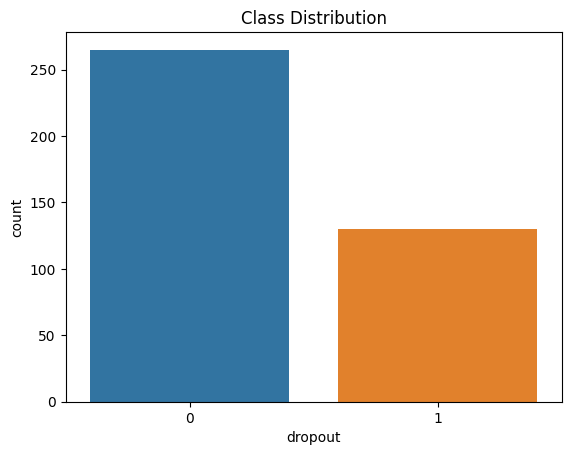

In [100]:
# checking the distribution of the values in the target column
sns.countplot(data=studentDropout_dataset, x='dropout')
plt.title('Class Distribution')
plt.show()


In [101]:
# Calculate class counts
class_counts = studentDropout_dataset['dropout'].value_counts()

# Calculate the imbalance ratio
imbalance_ratio = class_counts[0] / class_counts[1]
print("Imbalance Ratio:", imbalance_ratio)



Imbalance Ratio: 2.0384615384615383


In [102]:
# Assuming you have class_counts as calculated earlier
total_instances = sum(class_counts)

# Calculate the proportions of each class
class_proportions = class_counts / total_instances

# Calculate the Gini index
gini_index = 1 - np.sum(class_proportions**2)
print("Gini Index:", gini_index)


Gini Index: 0.4415958980932543


# Resampling of the dataframe to balance the target column

In [103]:
# Split your data into features (X) and the target variable (y)
X = studentDropout_dataset.drop('dropout', axis=1)
y = studentDropout_dataset['dropout']

# Initialize the SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to your dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

In [104]:
print("Shape of the resampled dataset:", X_resampled.shape, y_resampled.shape)

Shape of the resampled dataset: (530, 10) (530,)


In [105]:
# Create a DataFrame for X_resampled
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)

# Create a Series for y_resampled
y_resampled_series = pd.Series(y_resampled, name='dropout')

# Concatenate the DataFrame and the Series along the columns (axis=1)
studentDropout_dataset_resampled = pd.concat([X_resampled_df, y_resampled_series], axis=1)

# Your combined dataset is now stored in combined_resampled_dataset


In [106]:
studentDropout_dataset_resampled

,age,medu,mjob,reason,w_sTime,pc_failures,ftime,goingOut,Walc,health,dropout
0,18,4,0,0,1,0,2,3,0,2,1
1,17,1,0,0,1,0,2,2,0,2,1
2,15,1,0,1,1,3,2,1,2,2,0
3,15,4,3,2,2,0,1,1,0,4,0
4,16,3,4,2,1,0,2,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...
525,21,2,2,0,0,3,3,3,3,0,1
526,15,2,0,0,1,0,2,3,0,0,1
527,15,1,0,0,0,0,2,2,0,2,1
528,18,2,0,0,2,0,2,2,0,2,1


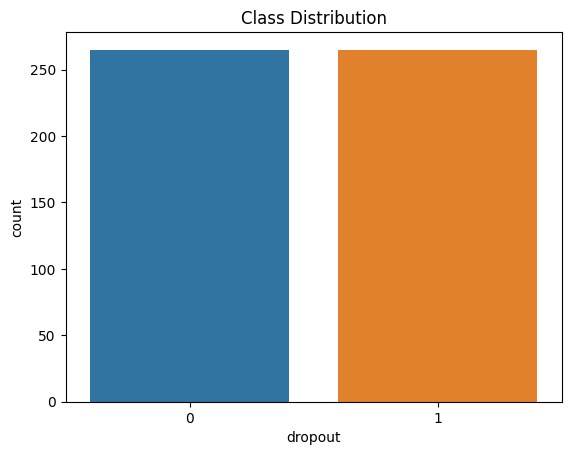

In [107]:
#after oversampling
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=studentDropout_dataset_resampled, x='dropout')
plt.title('Class Distribution')
plt.show()

# Training the dataset with the SVM model

In [108]:
X = studentDropout_dataset_resampled.drop('dropout', axis=1)  # Replace 'target_column' with the name of your target column
y = studentDropout_dataset_resampled['dropout']

# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Import the necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 10],
}

# Create an SVM classifier
svm_classifier = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the SVM model with the best hyperparameters
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Best Hyperparameters:", accuracy)

Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy with Best Hyperparameters: 0.6886792452830188


In [109]:
#when the best kernel was found from gridsearch, 'C' and 'gamma' hyperparamters are again tuned to find the best values for them
#then the model is retrained

import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer
svm = SVC(kernel='rbf')
param_grid = {
    'C': [0.1, 1, 10, 100],      # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1]  # Kernel coefficient for 'rbf'
}
scorer = make_scorer(f1_score)

grid_search = GridSearchCV(svm, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the best estimator (model)
best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_svm.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("Best hyperparameters:", best_params)
print("F1 Score on the test set:", f1)

Best hyperparameters: {'C': 10, 'gamma': 0.1}
F1 Score on the test set: 0.7130434782608696


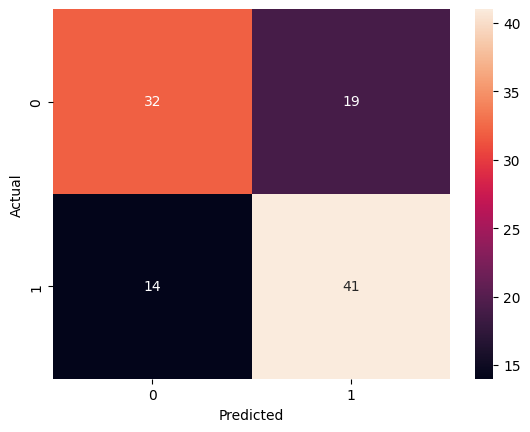

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [111]:
from sklearn.model_selection import cross_val_score

# Define your SVM model with the chosen kernel and initial hyperparameters
svm = SVC(kernel='rbf', C=1, gamma=0.01)  # Adjust C and gamma based on your tuning

# Perform cross-validation with k-fold (e.g., k=5) cross-validation
# You can use the scoring metric you're interested in (e.g., F1 score)
cv_scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='f1')

# Print the cross-validation scores and their mean
print("Cross-Validation Scores:", cv_scores)
svm_mean_f1 = cv_scores.mean()
print("Mean F1 Score:", svm_mean_f1)

Cross-Validation Scores: [0.75       0.60240964 0.62921348 0.71428571 0.675     ]
Mean F1 Score: 0.6741817671971997


# Training using RandomeForest Classifier

In [112]:
X = studentDropout_dataset_resampled.drop('dropout', axis=1)  # Replace 'target_column' with the name of your target column
y = studentDropout_dataset_resampled['dropout']

In [113]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40, 50, 60],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8, 12],
    'max_features': [1, 2, 3, 4, 5],
    'random_state': [50]
}

# Create the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to your training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best estimator
best_rf_classifier = grid_search.best_estimator_

# Make predictions using the best estimator
y_pred = best_rf_classifier.predict(X_test)

Best Hyperparameters: {'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 50}


In [115]:
# Create the RandomForestClassifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                            max_depth=best_params['max_depth'],
                                            min_samples_split=best_params['min_samples_split'],
                                            min_samples_leaf=best_params['min_samples_leaf'],
                                            max_features=best_params['max_features'],
                                            random_state=best_params['random_state'])

# Perform cross-validation and calculate F1 scores
f1_scores = cross_val_score(best_rf_classifier, X_train, y_train, cv=5, scoring=make_scorer(f1_score))

# Calculate the mean F1 score
random_forest_f1_score = f1_scores.mean()

print("Mean F1 Score:", random_forest_f1_score)

Mean F1 Score: 0.7572458973255446


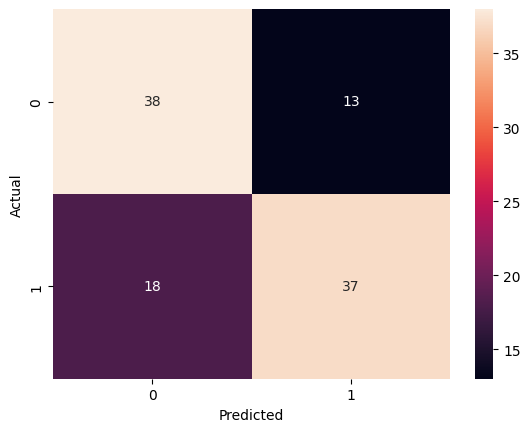

In [116]:
cm = confusion_matrix(y_test, y_pred) #Calculating the cinfusion matrix
sns.heatmap(cm, annot=True, fmt='d') #creates a heatmap
plt.xlabel('Predicted') # set labels for the x of the heatmap.
plt.ylabel('Actual') # set labels for the y of the heatmap.
plt.show() #displays the plot

# Traning using Logistic Regression model

In [117]:
X = studentDropout_dataset_resampled.drop('dropout', axis=1)  # Replace 'target_column' with the name of your target column
y = studentDropout_dataset_resampled['dropout']

In [118]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:

# Define a range of hyperparameters to search over
param_grid = {
    'penalty': ['l2'],        # Regularization type
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Algorithm to use in the optimization problem
}

# Create the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)

# Perform grid search with cross-validation to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_logistic_model = LogisticRegression(max_iter=1000, **best_params)
best_logistic_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = best_logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Accuracy: {accuracy}")

Best Model Accuracy: 0.6415094339622641


In [120]:
cross_val_scores = cross_val_score(best_logistic_model, X_train, y_train, cv=3, scoring='accuracy') # Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores) # Calculate the mean accuracy across all folds

# Print the cross-validation scores
print("Cross-Validation F1 Scores:", cross_val_scores) # Calculate the mean F1 score across all folds
mean_f1_score_logistic = cross_val_scores.mean()
print(f"Mean F1 Score: {mean_f1_score_logistic:.2f}")

Cross-Validation Scores: [0.71830986 0.60283688 0.68794326]
Cross-Validation F1 Scores: [0.71830986 0.60283688 0.68794326]
Mean F1 Score: 0.67


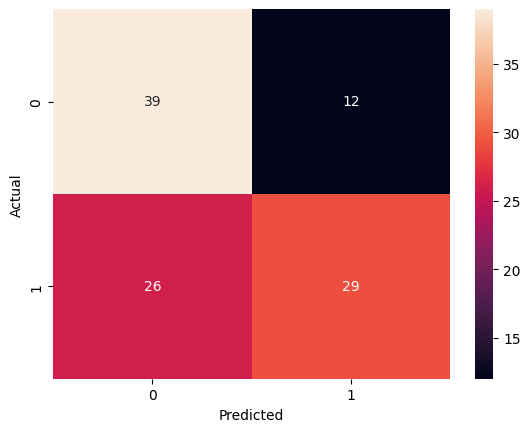

In [121]:
cm = confusion_matrix(y_test, y_pred) #Calculating the cinfusion matrix
sns.heatmap(cm, annot=True, fmt='d') #creates a heatmap
plt.xlabel('Predicted') # set labels for the x of the heatmap.
plt.ylabel('Actual') # set labels for the y of the heatmap.
plt.show() #displays the plot

# Traning using XGBoost model

In [122]:
# Split the dataset into training and testing sets
X = studentDropout_dataset_resampled.drop('dropout', axis=1)
y = studentDropout_dataset_resampled['dropout']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [3, 4, 5],  # Adjust the maximum depth of the trees
    'learning_rate': [0.01, 0.1, 0.2],  # Adjust the learning rate (eta)
    'n_estimators': [100, 200, 300],  # Adjust the number of boosting rounds
    'subsample': [0.8, 0.9, 1.0],  # Adjust the subsample ratio
    'colsample_bytree': [0.8, 0.9, 1.0],  # Adjust the fraction of features used by each tree
}

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

# Perform grid search with cross-validation to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_log_loss', cv=3)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Train the model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic', **best_params)
best_xgb_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = best_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Accuracy: {accuracy}")


Best Hyperparameters:
colsample_bytree: 0.8
learning_rate: 0.01
max_depth: 5
n_estimators: 300
subsample: 0.8
Best Model Accuracy: 0.6886792452830188


In [123]:
# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

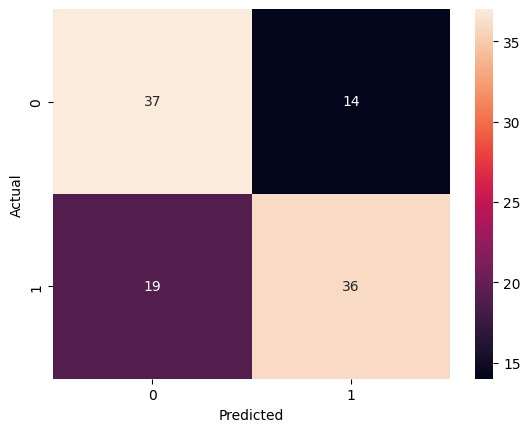

In [124]:
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [125]:
# Create an XGBoost model with regularization parameters
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    reg_lambda=1.0,  # Adjust the L2 regularization term
    reg_alpha=0.0,   # Adjust the L1 regularization term
    max_depth=5,     # Other hyperparameters
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=300
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.6886792452830188


In [126]:
# Create the XGBoost model with the best hyperparameters
xgb_model = xgb.XGBClassifier(objective='binary:logistic', **best_params)

# Perform cross-validation on the training data
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1')

# Calculate the mean and standard deviation of the cross-validation scores
mean_f1_XGBoost = np.mean(cv_scores)
std_cv_accuracy = np.std(cv_scores)

print("Cross-Validation F1 Score:")
print("Mean F1:", mean_f1_XGBoost)
print("Standard Deviation:", std_cv_accuracy)


Cross-Validation F1 Score:
Mean F1: 0.7106546974243825
Standard Deviation: 0.05137493560470445


In [127]:
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

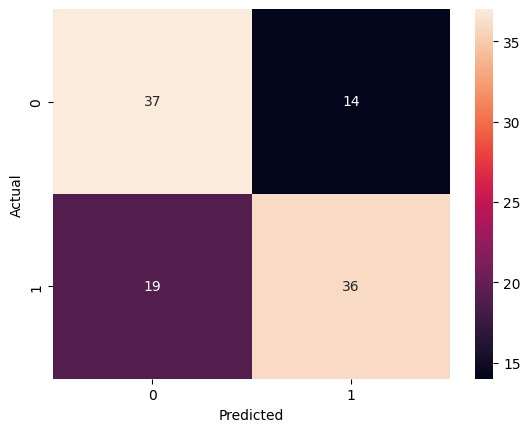

In [128]:
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

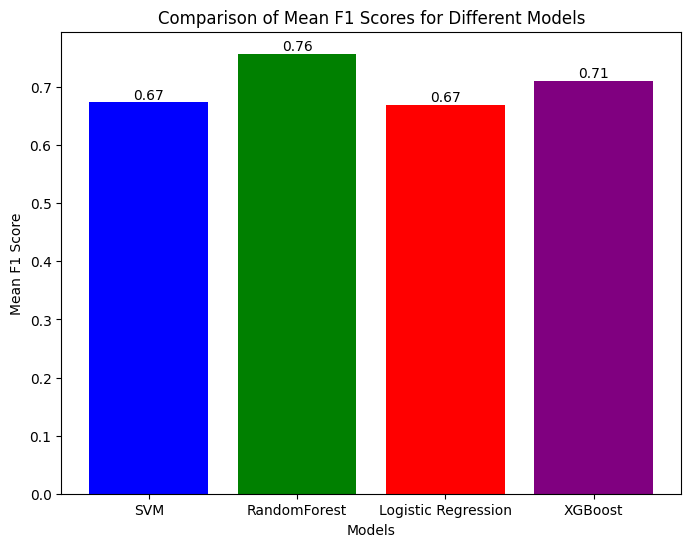

In [134]:
import matplotlib.pyplot as plt

# Four mean F1 scores
mean_f1_scores = [svm_mean_f1, random_forest_f1_score, mean_f1_score_logistic, mean_f1_XGBoost]  # Replace with your actual mean F1 scores

# Labels for each score
labels = ["SVM", "RandomForest", "Logistic Regression", "XGBoost"]  # Replace with your labels

# Define colors for each bar
colors = ['blue', 'green', 'red', 'purple']  # Add more colors as needed

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(labels, mean_f1_scores, color=colors)
plt.xlabel("Models")
plt.ylabel("Mean F1 Score")
plt.title("Comparison of Mean F1 Scores for Different Models")

# Add F1 scores on top of each bar
for i, score in enumerate(mean_f1_scores):
    plt.text(i, score, f'{score:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()
